This notebook creates synthetic data with 2 different rates, make igram pairs and show that it gives a TPC bias. 

<br>
Written on ? (was incorrect though) and edited on 10-19-23.

***
***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from scipy import signal
import scipy
%matplotlib  widget 

Define colormap where Nans are green

In [2]:
seismic2 = plt.cm.get_cmap("seismic").copy()
seismic2.set_bad(color='green')
print('colormap made where NANs will be green.')

colormap made where NANs will be green.


Create a mask for 2 populations. Defined by what percent is in pop1, rest in pop2.

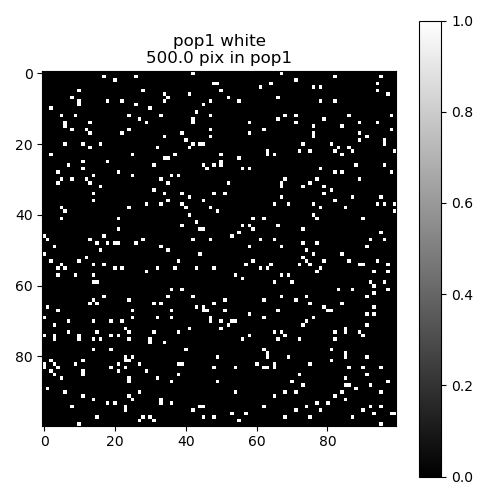

pop1: 500.0 pixels.
pop2: 9500.0 pixels.
percentage in pop1: 5.0


In [3]:
# dimensions of area
dx = 100
dy = 100
# percentage of pixels that are in pop1
pop1_percent = 5
# rate and std of rate
med = 0.0
std = 2.0

# create random values to select 
random_vals = np.random.normal(med,std,(dx,dy)) # median, std, size of array
mask = np.zeros((dx,dy))
mask[random_vals<np.percentile(random_vals.flatten(),pop1_percent)] = 1.0

plt.figure(figsize=(5,5),tight_layout=True)
plt.imshow(mask,cmap='gray',interpolation='none')
plt.colorbar(); plt.title('pop1 white\n'+str(np.sum(mask))+' pix in pop1')
plt.show()

print('pop1: '+str(np.sum(mask))+' pixels.')
print('pop2: '+str(dx*dy-np.sum(mask))+' pixels.')
print('percentage in pop1: '+str(np.sum(mask)/(dx*dy)*100))

Define disp rates and convert them from cm/yr to rad/igram which is what real data looks like.

In [4]:
# set velocities of each population.
pop1_vel = 0.0      # this is in cm/yr 
pop2_vel = 2.0      # this is in cm/yr 

# define a function to convert rate in cm/yr to rate in rad/igram
def vel2phs(vel,dt): # dt is in days, temporal baseline
    phs = vel/365.25*dt*4*np.pi/5.5465763
    return phs

# choose 12 days as temporal baseline for this test.
pop1_phs = vel2phs(pop1_vel,100)     # this is the phase per interferogram for these pixels with given rate
pop2_phs = vel2phs(pop2_vel,100)
print('phase in rad/igram created for each pop.')

# define the noise level, this will be the std of the Gaussian distribution when we create igram phase data.
noise_level = 0.5
print('noise level defined.')

phase in rad/igram created for each pop.
noise level defined.


In [5]:
print(vel2phs(2.0,12))
print(vel2phs(2.0,24))
print(vel2phs(2.0,100))

0.14886955476840863
0.29773910953681726
1.2405796230700719


Practice making a single igram (just phase) that combines the populations according to the mask.

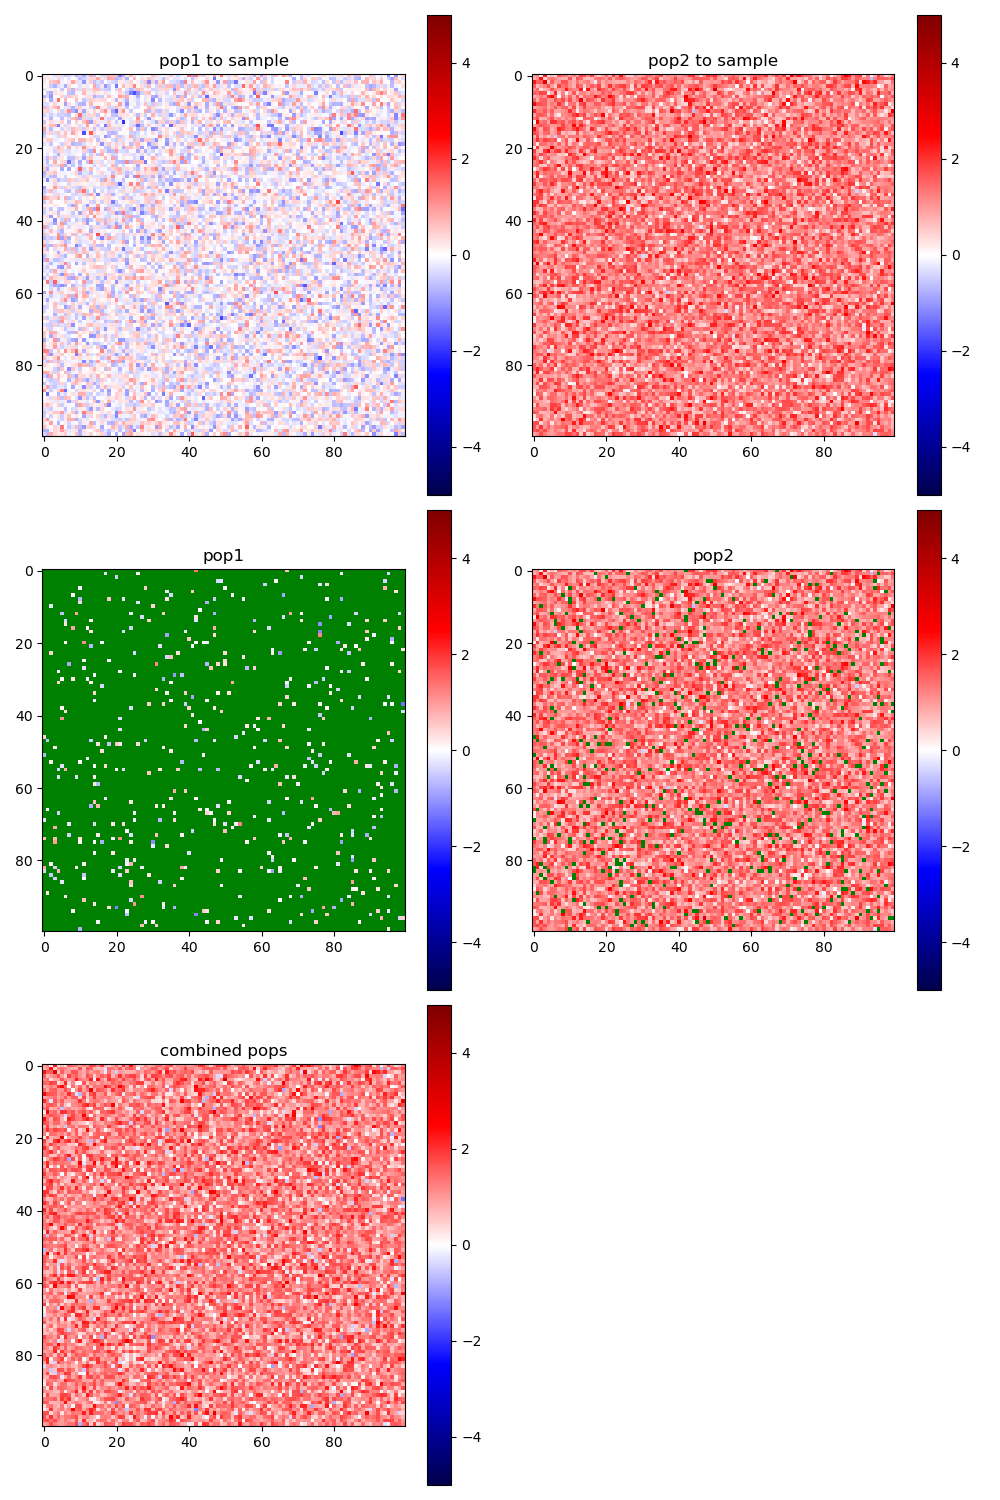

In [6]:
# start with what an igram would look like for each pop if all pixels were in that pop
pop1_to_sample = np.random.normal(pop1_phs,noise_level,(dy,dx)) # (center of distribution, std of distribution, size)
pop2_to_sample = np.random.normal(pop2_phs,noise_level,(dy,dx))

# follow mask to put in values from each pop into a combined pop synthetic igram.
pop1 = np.zeros((dy,dx))*np.nan
pop1[mask==1]=pop1_to_sample[mask==1] # keep these separate for plotting while troubleshooting.
pop2 = np.zeros((dy,dx))*np.nan
pop2[mask==0]=pop2_to_sample[mask==0]

pops12 = np.zeros((dy,dx))*np.nan
pops12[mask==1]=pop1_to_sample[mask==1] # now combine them and make sure it worked.
pops12[mask==0]=pop2_to_sample[mask==0]

plt.figure(figsize=(10,15),tight_layout=True)
plt.subplot(3,2,1)
plt.imshow(pop1_to_sample,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('pop1 to sample')
plt.subplot(3,2,2)
plt.imshow(pop2_to_sample,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('pop2 to sample')
plt.subplot(3,2,3)
plt.imshow(pop1,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('pop1')
plt.subplot(3,2,4)
plt.imshow(pop2,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('pop2')
plt.subplot(3,2,5)
plt.imshow(pops12,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('combined pops')
plt.show()

Now make the phase data complex (magnitude 1) for that test igram (from phase vals).

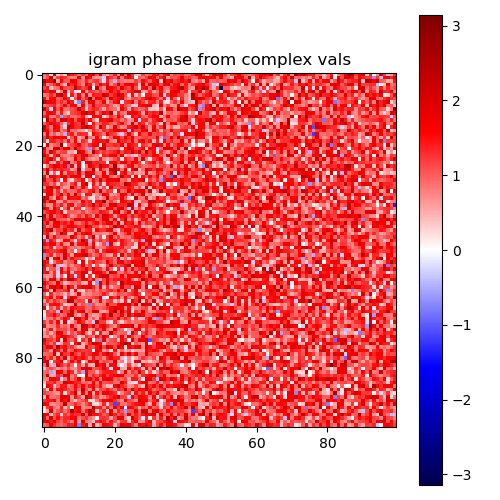

Yes, this worked. All magnitudes are 1.


In [7]:
igram_test = np.exp(1j*pops12)

# plot it to make sure angle(igram_test) is the same as the phases from above.
plt.figure(figsize=(5,5),tight_layout=True)
plt.imshow(np.angle(igram_test),cmap=seismic2,interpolation='none',vmin=-np.pi,vmax=np.pi)
plt.colorbar(); plt.title('igram phase from complex vals')
plt.show()
print('Yes, this worked. All magnitudes are 1.')

Write a function that creates a synthetic igram (complex with mags 1) with inputs:
1. given array size
2. pop1 percent
3. pop1 velocity
4. pop2 velocity
5. noise level for both pops
6. length of the igram in days.

In [8]:
def synthIgram(dy,dx,pop1_percent,pop1_vel,pop2_vel,phs_std,dt):
    # make population mask 
    random_vals = np.random.normal(0.0,2.0,(dx,dy)) # distribution for selecting given percentage of random pixels 
    mask = np.zeros((dy,dx))
    mask[random_vals<np.percentile(random_vals.flatten(),pop1_percent)] = 1.0 # set pop1 pixels to mask value 1

    # convert pop1 and pop2 velocities (cm/yr) to phs/igram
    pop1_phs = vel2phs(pop1_vel,dt)
    pop2_phs = vel2phs(pop2_vel,dt)
     
    # create sets of synthetic phase values for both pops 
    pop1_to_sample = np.random.normal(pop1_phs,phs_std,(dy,dx))
    pop2_to_sample = np.random.normal(pop2_phs,phs_std,(dy,dx))
    # combine them into single igram (still just phas vals though)
    pops12 = np.zeros((dy,dx))*np.nan
    pops12[mask==1]=pop1_to_sample[mask==1]
    pops12[mask==0]=pop2_to_sample[mask==0]

    # now make it complex
    igram_synth = np.exp(1j*pops12)

    # spit it out
    return igram_synth

Test the function at different pop1 percents.

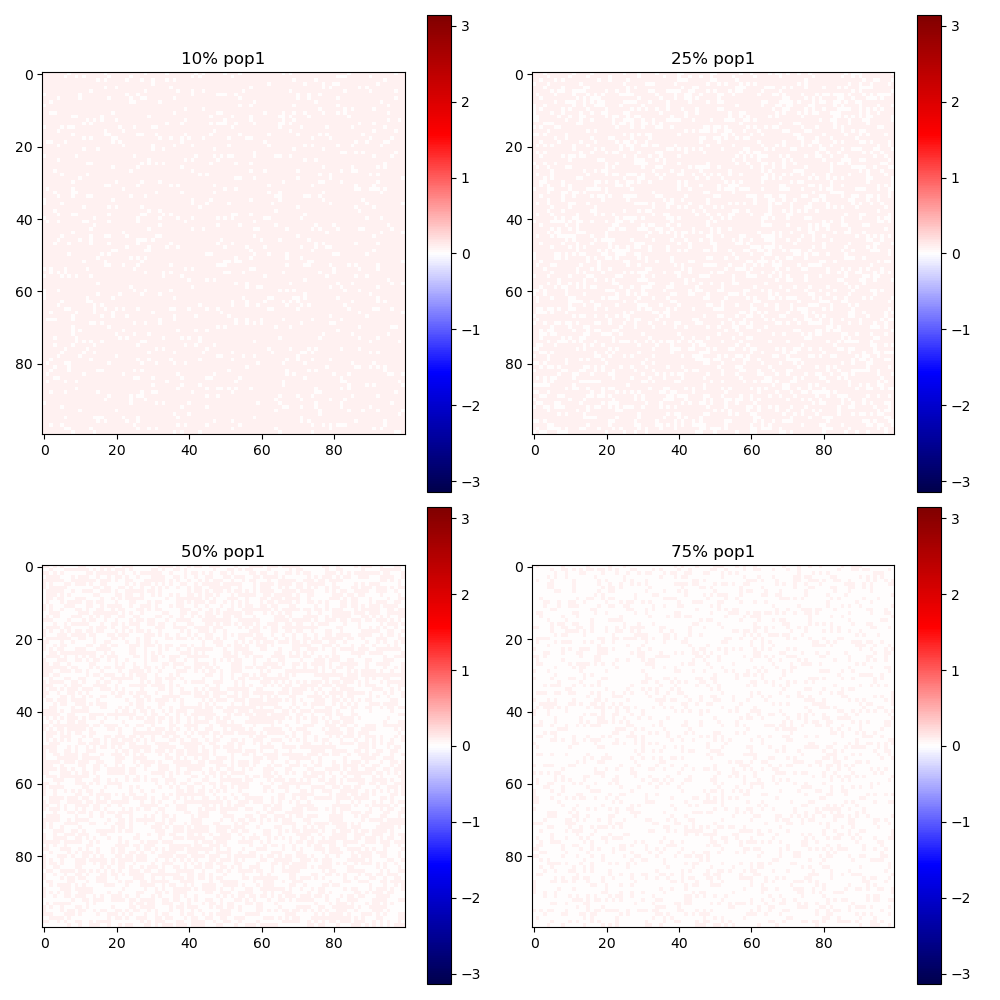

This seems to be working.


In [9]:
dy = 100
dx = 100
pop1_percent = 75
pop1_vel = 0.0
pop2_vel = -10.0
phs_std = 0.0
dt = 100

# marching through different pop1_percent inputs.
pop1_10_percent = synthIgram(dy,dx,10,pop1_vel,pop2_vel,phs_std,dt)
pop1_25_percent = synthIgram(dy,dx,25,pop1_vel,pop2_vel,phs_std,dt)
pop1_50_percent = synthIgram(dy,dx,50,pop1_vel,pop2_vel,phs_std,dt)
pop1_75_percent = synthIgram(dy,dx,75,pop1_vel,pop2_vel,phs_std,dt)

plt.figure(figsize=(10,10),tight_layout=True)
plt.subplot(2,2,1)
plt.imshow(np.angle(pop1_10_percent),cmap=seismic2,interpolation='none',vmin=-np.pi,vmax=np.pi)
plt.colorbar(); plt.title('10% pop1')
plt.subplot(2,2,2)
plt.imshow(np.angle(pop1_25_percent),cmap=seismic2,interpolation='none',vmin=-np.pi,vmax=np.pi)
plt.colorbar(); plt.title('25% pop1')
plt.subplot(2,2,3)
plt.imshow(np.angle(pop1_50_percent),cmap=seismic2,interpolation='none',vmin=-np.pi,vmax=np.pi)
plt.colorbar(); plt.title('50% pop1')
plt.subplot(2,2,4)
plt.imshow(np.angle(pop1_75_percent),cmap=seismic2,interpolation='none',vmin=-np.pi,vmax=np.pi)
plt.colorbar(); plt.title('75% pop1')
plt.show()

print('This seems to be working.')

Create a single triplet.

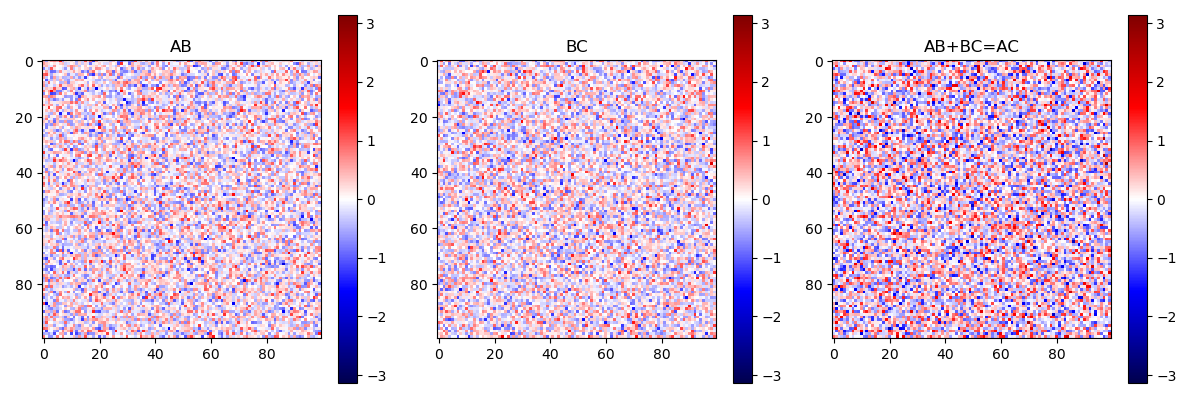

In [10]:
# input variables. Can be the same or different as test above.
dy = 100
dx = 100
pop1_percent = 90
pop1_vel = 0.0
pop2_vel = 2.0
phs_std = 0.5
dt = 12

# filter size for calculating TPC
xlooks = 5
ylooks = 5

# create three igrams: AB, BC (same inputs), and AC (double dt)
AB = synthIgram(dy,dx,pop1_percent,pop1_vel,pop2_vel,phs_std,dt)
BC = synthIgram(dy,dx,pop1_percent,pop1_vel,pop2_vel,phs_std,dt)

# THIS DIDN'T WORK: WHY???
AC = synthIgram(dy,dx,pop1_percent,pop1_vel,pop2_vel,phs_std,dt*2) # double the dt which gives double the phs in rad/igram 
# instead, I'm adding AB and BC and making it complex. 
AC = np.exp(1j*(np.angle(AB)+np.angle(BC)))

# plot them to check.
plt.figure(figsize=(12,4),tight_layout=True)
plt.subplot(1,3,1)
plt.imshow(np.angle(AB),cmap=seismic2,interpolation='none',vmin=-np.pi,vmax=np.pi)
plt.colorbar(); plt.title('AB')
plt.subplot(1,3,2)
plt.imshow(np.angle(BC),cmap=seismic2,interpolation='none',vmin=-np.pi,vmax=np.pi)
plt.colorbar(); plt.title('BC')
plt.subplot(1,3,3)
#plt.imshow(np.angle(AB)+np.angle(BC),cmap=seismic2,interpolation='none',vmin=-np.pi,vmax=np.pi)
plt.imshow(np.angle(AC),cmap=seismic2,interpolation='none',vmin=-np.pi,vmax=np.pi)
plt.colorbar(); plt.title('AB+BC=AC')
plt.show()

Plot a histogram of the phases of AB, BC, and AC. They should look similar to Gaussians. 

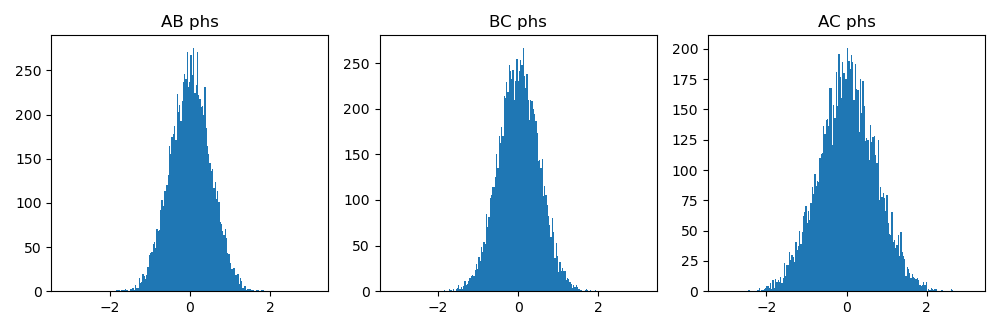

AB skew: -0.024447677697710515
BC skew: -0.0027831979918316583
AC skew: 0.014003101599529758


In [11]:
plt.figure(figsize=(10,3.3),tight_layout=True)
bins = np.linspace(-np.pi,np.pi,200)
plt.subplot(1,3,1)
plt.hist((np.angle(AB).flatten()),bins=bins)
plt.title('AB phs')
plt.subplot(1,3,2)
plt.hist((np.angle(BC).flatten()),bins=bins)
plt.title('BC phs')
plt.subplot(1,3,3)
plt.hist((np.angle(AB)+np.angle(BC)).flatten(),bins=bins)
plt.title('AC phs')
plt.show()

print('AB skew: '+str(scipy.stats.skew((np.angle(AB).flatten()))))
print('BC skew: '+str(scipy.stats.skew((np.angle(BC).flatten()))))
print('AC skew: '+str(scipy.stats.skew((np.angle(AB)+np.angle(BC)).flatten())))

Filter them and calculate TPC for the triplet.

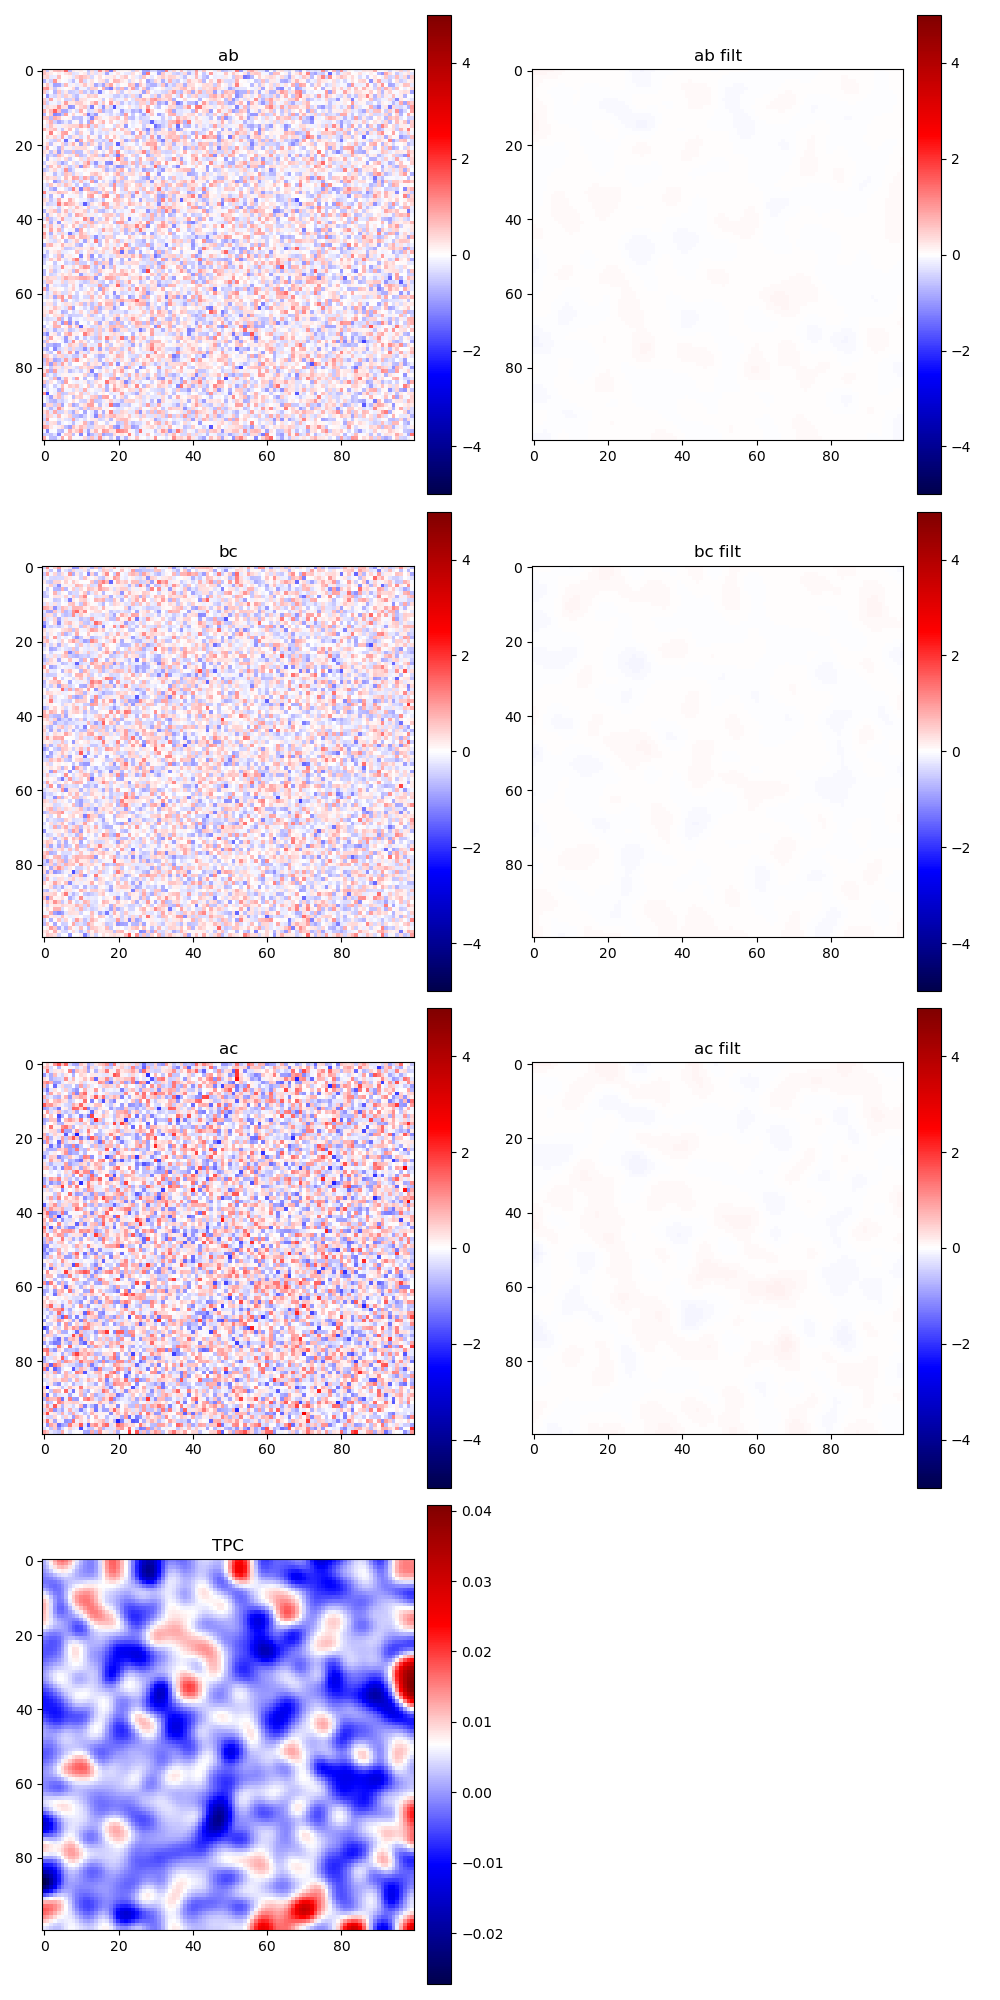

In [12]:
# filter them: real and imag parts separately 
AB_filt_r = gaussian_filter(np.real(AB),sigma=[xlooks/2,ylooks/2])
AB_filt_i = gaussian_filter(np.imag(AB),sigma=[xlooks/2,ylooks/2])
AB_filt = AB_filt_r + np.exp(1j*AB_filt_i)
BC_filt_r = gaussian_filter(np.real(BC),sigma=[xlooks/2,ylooks/2])
BC_filt_i = gaussian_filter(np.imag(BC),sigma=[xlooks/2,ylooks/2])
BC_filt = BC_filt_r + np.exp(1j*BC_filt_i)
AC_filt_r = gaussian_filter(np.real(AC),sigma=[xlooks/2,ylooks/2])
AC_filt_i = gaussian_filter(np.imag(AC),sigma=[xlooks/2,ylooks/2])
AC_filt = AC_filt_r + np.exp(1j*AC_filt_i)


# calculate TPC
ABC_TPC = np.angle(AB_filt) + np.angle(BC_filt) - np.angle(AC_filt)

plt.figure(figsize=(10,20),tight_layout=True)
plt.subplot(4,2,1)
plt.imshow(np.angle(AB),cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(orientation='vertical',pad=0.03); plt.title('ab')
plt.subplot(4,2,2)
plt.imshow(np.angle(AB_filt),cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(orientation='vertical',pad=0.03); plt.title('ab filt')
plt.subplot(4,2,3)
plt.imshow(np.angle(BC),cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(orientation='vertical',pad=0.03); plt.title('bc')
plt.subplot(4,2,4)
plt.imshow(np.angle(BC_filt),cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(orientation='vertical',pad=0.03); plt.title('bc filt')
plt.subplot(4,2,5)
plt.imshow(np.angle(AC),cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(orientation='vertical',pad=0.03); plt.title('ac')
plt.subplot(4,2,6)
plt.imshow(np.angle(AC_filt),cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(orientation='vertical',pad=0.03); plt.title('ac filt')
plt.subplot(4,2,7)
plt.imshow(ABC_TPC,cmap=seismic2,interpolation='none')
plt.colorbar(orientation='vertical',pad=0.03); plt.title('TPC')
plt.show()

Loop over a bunch of triplets, save the BC igram and make it the new AB as we march through time. Accumulate the TPCs. 

In [15]:
cum_TPC = np.zeros((dy,dx))

# set the inputs to synthIgram
dy = 100
dx = 100
pop1_percent = 90
pop1_vel = 0.0
pop2_vel = 2.0
phs_std = 0.5
dt = 12
# filter size
xlooks = 5
ylooks = 5

for i in range(100): # start with 100 triplets
    if i==0:
        # first time through loop: create all three igrams.
        AB = synthIgram(dy,dx,pop1_percent,pop1_vel,pop2_vel,phs_std,dt)
        BC = synthIgram(dy,dx,pop1_percent,pop1_vel,pop2_vel,phs_std,dt)
        AC = np.exp(1j*(np.angle(AB)+np.angle(BC)))
    else:
        # if not the first run, don't need to make AB again. Comes from the old BC
        BC = synthIgram(dy,dx,pop1_percent,pop1_vel,pop2_vel,phs_std,dt)
        AC = np.exp(1j*(np.angle(AB)+np.angle(BC)))

    # filter them: real and imag parts separately 
    AB_filt_r = gaussian_filter(np.real(AB),sigma=[xlooks/2,ylooks/2])
    AB_filt_i = gaussian_filter(np.imag(AB),sigma=[xlooks/2,ylooks/2])
    AB_filt = AB_filt_r + np.exp(1j*AB_filt_i)
    BC_filt_r = gaussian_filter(np.real(BC),sigma=[xlooks/2,ylooks/2])
    BC_filt_i = gaussian_filter(np.imag(BC),sigma=[xlooks/2,ylooks/2])
    BC_filt = BC_filt_r + np.exp(1j*BC_filt_i)
    AC_filt_r = gaussian_filter(np.real(AC),sigma=[xlooks/2,ylooks/2])
    AC_filt_i = gaussian_filter(np.imag(AC),sigma=[xlooks/2,ylooks/2])
    AC_filt = AC_filt_r + np.exp(1j*AC_filt_i)
    # calculate TPC
    ABC_TPC = np.angle(AB_filt) + np.angle(BC_filt) - np.angle(AC_filt)
    # add it to cumulative TPC array 
    cum_TPC += ABC_TPC

    # now set BC to become the new AB since that igram will be in the next triplet. 
    AB = BC

Plot the cumulative TPC now.

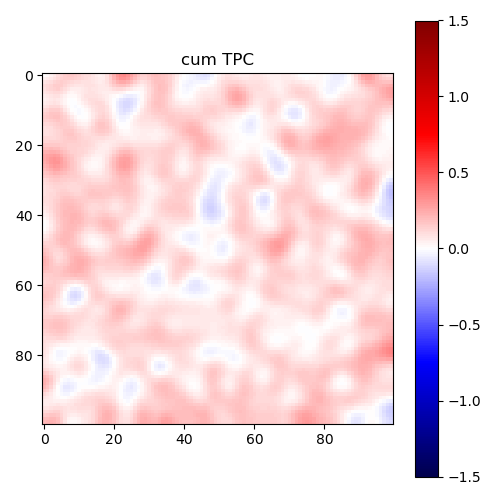

In [16]:
plt.figure(figsize=(5,5),tight_layout=True)
plt.imshow(cum_TPC,cmap=seismic2,interpolation='none',vmin=-1.5,vmax=1.5)
plt.colorbar(); plt.title('cum TPC')
plt.show()